<!-- # CNN autoencoder and Clustering from MTRX data

Use this notebook to load Scienta Omicron Matrix format SPM data and create standardised images for machine learning training and analysis. The code can generate both JPG image data, useful for manually checking the data, and windowed numpy data that can be loaded into ML models. 

The notebook then creates an autoencoder for training on a large dataset, followed by KMEANS clustering. 

**Author**: Steven R. Schofield  
**Created**: November, 2024 -->

# CASTEP - Si lattice parameter optimisations
## Steven R. Schofield (Universtiy College London) May 2025

### Load required modules

In [1]:
import sys
from pathlib import Path

# Define candidate paths using Path objects
module_path_list = [
    Path('/Users/steven/academic-iCloud/Python/modules'),
    Path('/hpc/srs/Python/modules')
]

data_path_list = [
    Path('/Users/steven/academic-iCloud/Calculations/castep/'),
    Path('/hpc/srs/castep')
]

# Resolve actual paths
module_path = next((p for p in module_path_list if p.exists()), None)
data_path = next((p for p in data_path_list if p.exists()), None)

# Check and report missing paths
if module_path is None:
    print("Error: Could not locate a valid module path.")
if data_path is None:
    print("Error: Could not locate a valid data path.")

if module_path is None or data_path is None:
    sys.exit(1)

# Add module_path to sys.path if needed
if str(module_path) not in sys.path:
    sys.path.insert(0, str(module_path))

# Print resolved paths
print(f"module_path = {module_path}")
print(f"data_path = {data_path}")

module_path = /hpc/srs/Python/modules
data_path = /hpc/srs/castep


In [3]:
# # Ensure modules are reloaded 
%load_ext autoreload
%autoreload 2

%matplotlib notebook


# Import standard modules
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt

# Import custom module
import SRSCALCUTILS.castep_tools as ct

from IPython.display import display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Job paths

In [4]:
# Parameters for windows creation
# General
job_folder = 'work-2025/si001_lat'
job_path = data_path / job_folder
verbose = False             # Set this True to print out more information

# Print resolved paths
print(f"job_path = {job_path}")

job_path = /hpc/srs/castep/work-2025/si001_lat


### Create CASTEP input files

In [5]:
# Set up the param and cell files for the calculation

filename = "silicon"
title = "silicon lattice parameter optimisation"

params = {'task' : 'geomopt',
          'xc_functional'           : 'PBE',
          'cut_off_energy'          : 700,
          'spin_polarised'          : 'false',
          'write_cell_structure'    : 'true',
          'charge'                  : 0,
          'nextra_bands'            : 4,
          'geom_energy_tol'         : 0.00005,          # default: 0.00005 eV 
          'geom_disp_tol'           : 0.002,            # default: 0.002 Ang.
          'geom_max_iter'           : 100,              # default: 30
          'geom_convergence_win'    : 2,                # default: 2
          'max_scf_cycles'          : 300               # default: 30
          }              

na=1
nb=1
nc=1

lattice_cart = np.array([
            [3.8,     0.0,     0.0],
            [0.0,     3.8,     0.0],
            [0.0,     0.0,     5.4,]
        ])

positions_frac = np.array([
            ['Si', 0.0,  0.0,  0.0],
            ['Si', 0.5,  0.0,  0.25],
            ['Si', 0.5,  0.5,  0.5],
            ['Si', 0.0,  0.5,  0.75],
        ])

constraints = np.array([
            [1,  1,  2],
            [0,  0,  0]
        ])

kpoints_mp_grid = np.array([8, 8, 8])

fix_all_ions = True
symmetry_generate=False
symmetry_tol = 0.01

In [6]:
# If it doesn’t exist, create it (including any missing parent folders)
if not os.path.isdir(job_path):
    os.makedirs(job_path, exist_ok=True)

# Now safely switch into it
os.chdir(job_path)

print("Now in:", os.getcwd())
print("Files:", os.listdir())

Now in: /hpc/srs/castep/work-2025/si001_lat
Files: []


In [7]:
!export OMP_NUM_THREADS=2
cores = 62

### Convergence with cut off energy

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-400.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-400.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-400.cell
Wed 21 May 16:46:33 BST 2025

There are some micro-organisms that exhibit characteristics of both plants
and animals.  When exposed to light they undergo photosynthesis; and when
the lights go out, they turn into animals.  But then again, don't we all?

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-500.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-500.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-500.cell
Wed 21 May 16:46:53 BST 2025

Voiceless it cries,
Wingless flutters,
Toothless bites,
Mouthless mutters.

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-600.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-cut-600.param
Wrote cell file to: /hpc/srs/c

<IPython.core.display.Javascript object>

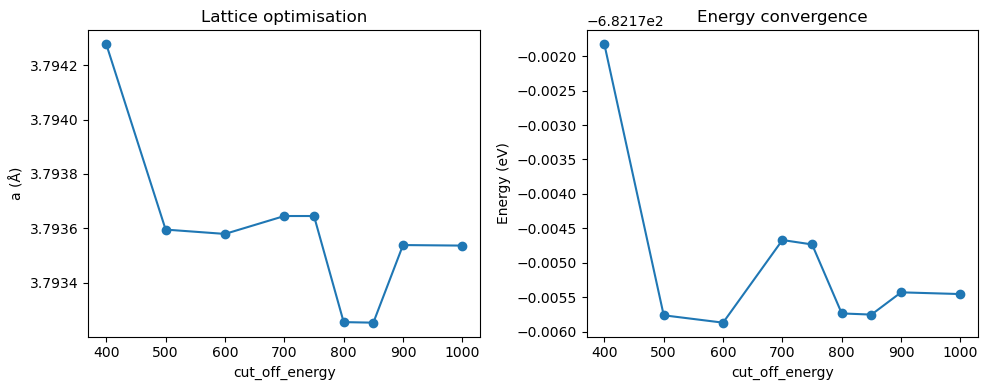

,Cut off energy (eV),Lattice constant (Å),Energy
0,400,3.794278,-682.171828
1,500,3.793595,-682.175761
2,600,3.793579,-682.175868
3,700,3.793645,-682.174669
4,750,3.793645,-682.174733
5,800,3.793254,-682.175734
6,850,3.793252,-682.175751
7,900,3.793538,-682.175428
8,1000,3.793536,-682.175453


In [ ]:
var_list = [400,500,600,700,750,800,850,900,1000]
kpoints_mp_grid = np.array([4,4,1])

a_list = []
energy_list = []

for var in var_list:
    params['cut_off_energy'] = var
    
    filename = f"silicon-cut-{var}"
    castep_path = job_path / f"{filename}.castep"
    
    print('=' * 80 + f'\nCASTEP file: {castep_path}\n' + '=' * 80 + '\n')   

    _ = ct.write_param_file(
        params,
        title = title,
        filename=filename,
        path=job_path,
        display_file=False
        )
    
    _ = ct.write_bulk_cell_file(
        title = title,
        path=job_path,
        filename=filename,
        na=na,
        nb=nb,
        nc=nc,
        lattice_cart=lattice_cart,
        positions_frac=positions_frac,
        constraints=constraints,
        fix_all_ions=True,
        symmetry_generate=symmetry_generate,
        symmetry_tol = symmetry_tol,
        kpoints_mp_grid=kpoints_mp_grid,
        display_file=False
    )
    
    if str(module_path) == '/hpc/srs/Python/modules':
        !bash -l -c "mpirun -np {cores} castep.mpi {filename}"
    else:
        !zsh -l -c "castepmpi {filename}"

    unit_cell, a, b, c, alpha, beta, gamma = ct.get_final_lattice_parameters(castep_path)
    energy_optimisation = ct.get_LBFGS_energies(castep_path)
    energies = [val for _, val in energy_optimisation]
    energy = energies[-1]
    
    # parse out `a` and final `energy`
    a_list.append(a)
    energy_list.append(energy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# redraw lattice‐constant plot
ax1.clear()
ax1.plot(var_list[:len(a_list)], a_list, marker='o')
ax1.set(xlabel='cut_off_energy', ylabel='a (Å)', title='Lattice optimisation')

# redraw energy plot
ax2.clear()
ax2.plot(var_list[:len(energy_list)], energy_list, marker='o')
ax2.set(xlabel='cut_off_energy', ylabel='Energy (eV)', title='Energy convergence')

fig.tight_layout()
display(fig)

df = pd.DataFrame({"Cut off energy (eV)": var_list,"Lattice constant (Å)": a_list,"Energy": energy_list,})
display( df)

### Convergence with k points

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.cell
Wed 21 May 16:50:29 BST 2025

You own a dog, but you can only feed a cat.

 SWAPPING NZ=1
 dummy: recip_pg_cols before swap:           7           6           6
           6           6
 dummy: real_pg_rows  before swap:           6           5           5
           5           5           5
 dummy: recip_pg_cols after swap:           6           6           7
           6           6
 
 pg-col=           1
 node=           1
 node=           2
 node=           3
 node=           4
 node=           5
 node=           6
 
 pg-col=           2
 node=           7
 node=           8
 node=           9
 node=          10
 node=          11
 node=          12
 
 pg-col=           3
 node=          13
 node=          14
 node=          15
 node=          16
 node=          17

<IPython.core.display.Javascript object>

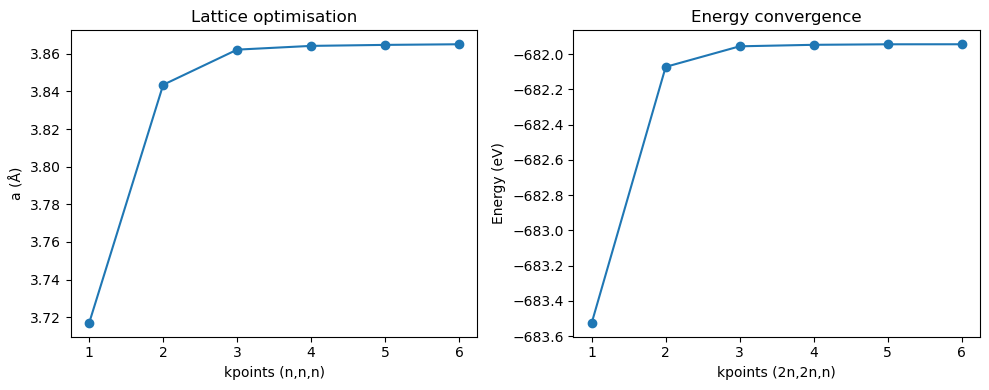

,k-points (2n 2n n),Lattice constant (Å),Energy
0,1,3.717065,-683.524381
1,2,3.843523,-682.071765
2,3,3.862205,-681.955070
3,4,3.864198,-681.946545
4,5,3.864728,-681.943611
5,6,3.865063,-681.943428


In [ ]:
var_list = [1,2,3,4,5,6]
params['cut_off_energy'] = 700

a_list = []
energy_list = []

for var in var_list:
    kpoints_mp_grid = np.array([2*var,2*var,var])
    
    filename = f"silicon-kk-{2*var}"
    castep_path = job_path / f"{filename}.castep"
    
    print('=' * 80 + f'\nCASTEP file: {castep_path}\n' + '=' * 80 + '\n')   

    _ = ct.write_param_file(
        params,
        title = title,
        filename=filename,
        path=job_path,
        display_file=False
        )
    
    _ = ct.write_bulk_cell_file(
        title = title,
        path=job_path,
        filename=filename,
        na=na,
        nb=nb,
        nc=nc,
        lattice_cart=lattice_cart,
        positions_frac=positions_frac,
        constraints=constraints,
        fix_all_ions=True,
        symmetry_generate=symmetry_generate,
        symmetry_tol = symmetry_tol,
        kpoints_mp_grid=kpoints_mp_grid,
        display_file=False
    )
    
    if str(module_path) == '/hpc/srs/Python/modules':
        !bash -l -c "mpirun -np {cores} castep.mpi {filename}"
    else:
        !zsh -l -c "castepmpi {filename}"

    unit_cell, a, b, c, alpha, beta, gamma = ct.get_final_lattice_parameters(castep_path)
    energy_optimisation = ct.get_LBFGS_energies(castep_path)
    energies = [val for _, val in energy_optimisation]
    energy = energies[-1]
    
    # parse out `a` and final `energy`
    a_list.append(a)
    energy_list.append(energy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# redraw lattice‐constant plot
ax1.clear()
ax1.plot(var_list[:len(a_list)], a_list, marker='o')
ax1.set(xlabel='kpoints (n,n,n)', ylabel='a (Å)', title='Lattice optimisation')

# redraw energy plot
ax2.clear()
ax2.plot(var_list[:len(energy_list)], energy_list, marker='o')
ax2.set(xlabel='kpoints (2n,2n,n)', ylabel='Energy (eV)', title='Energy convergence')

fig.tight_layout()
display(fig)

df = pd.DataFrame({"k-points (2n 2n n)": var_list,"Lattice constant (Å)": a_list,"Energy": energy_list,})
display( df)

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-2.cell
Wed 21 May 16:56:35 BST 2025

<dark> Culus: Building a five-meter-high replica of the Empire State
       Building with paperclips is impressive.  Doing it blindfolded is
       eleet.

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-3.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-3.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-3.cell
Wed 21 May 16:57:02 BST 2025

When you get your PH.D. will you get able to work at BURGER KING?

CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-4.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-4.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-kk-4.cell
Wed 21 May 16:57:44 BST 2025

It is the quality rather th

<IPython.core.display.Javascript object>

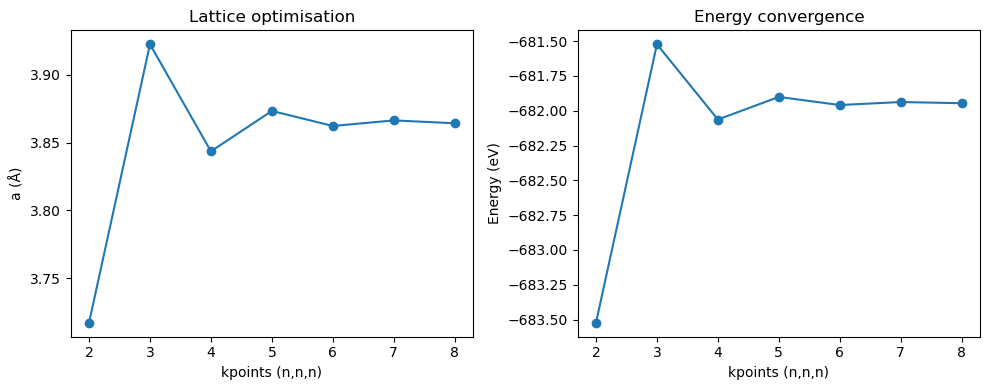

,k-points (n n n),Lattice constant (Å),Energy
0,2,3.717065,-683.523396
1,3,3.922461,-681.522106
2,4,3.843523,-682.062805
3,5,3.873286,-681.900504
4,6,3.862205,-681.958772
5,7,3.866314,-681.937070
6,8,3.864198,-681.945838


In [ ]:
var_list = [2,3,4,5,6,7,8]
params['cut_off_energy'] = 700

a_list = []
energy_list = []

for var in var_list:
    kpoints_mp_grid = np.array([var,var,var])
    
    filename = f"silicon-kk-{var}"
    castep_path = job_path / f"{filename}.castep"
    
    print('=' * 80 + f'\nCASTEP file: {castep_path}\n' + '=' * 80 + '\n')   

    _ = ct.write_param_file(
        params,
        title = title,
        filename=filename,
        path=job_path,
        display_file=False
        )
    
    _ = ct.write_bulk_cell_file(
        title = title,
        path=job_path,
        filename=filename,
        na=na,
        nb=nb,
        nc=nc,
        lattice_cart=lattice_cart,
        positions_frac=positions_frac,
        constraints=constraints,
        fix_all_ions=True,
        symmetry_generate=symmetry_generate,
        symmetry_tol = symmetry_tol,
        kpoints_mp_grid=kpoints_mp_grid,
        display_file=False
    )
    
    if str(module_path) == '/hpc/srs/Python/modules':
        !bash -l -c "mpirun -np {cores} castep.mpi {filename}"
    else:
        !zsh -l -c "castepmpi {filename}"

    unit_cell, a, b, c, alpha, beta, gamma = ct.get_final_lattice_parameters(castep_path)
    energy_optimisation = ct.get_LBFGS_energies(castep_path)
    energies = [val for _, val in energy_optimisation]
    energy = energies[-1]
    
    # parse out `a` and final `energy`
    a_list.append(a)
    energy_list.append(energy)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# redraw lattice‐constant plot
ax1.clear()
ax1.plot(var_list[:len(a_list)], a_list, marker='o')
ax1.set(xlabel='kpoints (n,n,n)', ylabel='a (Å)', title='Lattice optimisation')

# redraw energy plot
ax2.clear()
ax2.plot(var_list[:len(energy_list)], energy_list, marker='o')
ax2.set(xlabel='kpoints (n,n,n)', ylabel='Energy (eV)', title='Energy convergence')

fig.tight_layout()
display(fig)

df = pd.DataFrame({"k-points (n n n)": var_list,"Lattice constant (Å)": a_list,"Energy": energy_list,})
display( df)

In [11]:
# var_list = [200,300,400,500,600,700,800]
# alist = []
# energy_list = []

# cores = 96

# for var in var_list:
#     params['cut_off_energy'] = var
#     filename = f"silicon-{var}"
#     print('\n' * 4)
#     print('=' * 80)
#     castep_file = str(job_path)+'/'+filename+'.castep'
#     print('CASTEP file: {}'.format(castep_file))
#     print('=' * 80)
#     _ = ct.write_param_file(
#         params,
#         title = title,
#         filename=filename,
#         path=job_path,
#         display_file=False
#         )
    
#     _ = ct.write_cell_file(
#         title = title,
#         path=job_path,
#         filename=filename,
#         na=na,
#         nb=nb,
#         nc=nc,
#         lattice_cart=lattice_cart,
#         positions_frac=positions_frac,
#         constraints=constraints,
#         fix_all_ions=True,
#         symmetry_generate=symmetry_generate,
#         symmetry_tol = symmetry_tol,
#         kpoints_mp_grid=kpoints_mp_grid,
#         display_file=False
#     )
    
    
#     if str(module_path) == '/hpc/srs/Python/modules':
#         !bash -l -c "mpirun -np {cores} castep.mpi {filename}"
#     else:
#         !zsh -l -c "castepmpi {filename}"

#     # castep_path = job_path / f"{filename}.castep"

#     # warnings = ct.get_warnings(castep_path, verbose=True)

#     # calculation_parameters = ct.get_calculation_parameters(castep_path)
#     # calculation_parameters_df = pd.DataFrame(list(calculation_parameters.items()), columns=['Parameter', 'Value'])

#     # lattice_optimisation = ct.get_lattice_parameters(castep_path)
#     # a_values = [blk['a'] for blk in lattice_optimisation]

#     # unit_cell, a, b, c, alpha, beta, gamma = ct.get_final_lattice_parameters(castep_path)

#     # energy_optimisation = ct.get_LBFGS_energies(castep_path)
#     # energies = [val for _, val in energy_optimisation]

#     # ct.print_filename(castep_path)
#     # print(warnings)
#     # display(calculation_parameters_df)

#     # ct.plot_sequence(a_values, xlabel='Iteration', ylabel='a (Å)', title='Lattice parameter optimisation')
#     # ct.plot_sequence(energies, xlabel='Iteration', ylabel='Energy (eV)', title='Optimisation')

#     # print(f"Final unit cell")
#     # for vector in unit_cell:
#     #     print(f"\t {vector}")
#     # print(f"Final a = {a:.4f} b = {b:.4f} c = {c:.4f} alpha = {alpha:.4f} beta = {beta:.4f} gamma = {gamma:.4f}\n")

#     # alist.append(a)
#     # energy_list.append(energies[-1])

# ct.plot_sequence(energy_list, var_list, xlabel='cut_off_energy', ylabel='Energy (eV)', title='Optimisation')
# ct.plot_sequence(alist, var_list, xlabel='cut_off_energy', ylabel='Lattice a (Ang.)', title='Optimisation')

# import pandas as pd

# df = pd.DataFrame({
#     "Cut off energy (eV)": var_list,
#     "Lattice constant (Å)": alist,
#     "Energy": energy_list,
# })

# display( df)


### Optimised params

In [31]:
# Set up the param and cell files for the calculation

filename = "silicon"
title = "silicon lattice parameter optimisation"

params = {'task' : 'geomopt',
          'xc_functional'           : 'PBE',
          'cut_off_energy'          : 700,
          'spin_polarised'          : 'false',
          'write_cell_structure'    : 'true',
          'charge'                  : 0,
          'nextra_bands'            : 4,
          'geom_energy_tol'         : 0.00005,          # default: 0.00005 eV 
          'geom_disp_tol'           : 0.002,            # default: 0.002 Ang.
          'geom_max_iter'           : 100,              # default: 30
          'geom_convergence_win'    : 2,                # default: 2
          'max_scf_cycles'          : 300               # default: 30
          }              

na=1
nb=1
nc=1

lattice_cart = np.array([
            [3.8641976,     0.0,     0.0],
            [0.0,     3.8641976,     0.0],
            [0.0,     0.0,     5.4648012]
        ])

positions_frac = np.array([
            ['Si', 0.0,  0.0,  0.0],
            ['Si', 0.5,  0.0,  0.25],
            ['Si', 0.5,  0.5,  0.5],
            ['Si', 0.0,  0.5,  0.75],
        ])

constraints = np.array([
            [1,  1,  2],
            [0,  0,  0]
        ])

kpoints_mp_grid = np.array([8, 8, 4])

fix_all_ions = True
symmetry_generate=False
symmetry_tol = 0.01

In [ ]:
filename = f"silicon-optimised"
castep_path = job_path / f"{filename}.castep"

print('=' * 80 + f'\nCASTEP file: {castep_path}\n' + '=' * 80 + '\n')   

_ = ct.write_param_file(
    params,
    title = title,
    filename=filename,
    path=job_path,
    display_file=False
    )

_ = ct.write_bulk_cell_file(
    title = title,
    path=job_path,
    filename=filename,
    na=na,
    nb=nb,
    nc=nc,
    lattice_cart=lattice_cart,
    positions_frac=positions_frac,
    constraints=constraints,
    fix_all_ions=True,
    symmetry_generate=symmetry_generate,
    symmetry_tol = symmetry_tol,
    kpoints_mp_grid=kpoints_mp_grid,
    display_file=False
)

if str(module_path) == '/hpc/srs/Python/modules':
    !bash -l -c "mpirun -np {cores} castep.mpi {filename}"
else:
    !zsh -l -c "castepmpi {filename}"

unit_cell, a, b, c, alpha, beta, gamma = ct.get_final_lattice_parameters(castep_path)
energy_optimisation = ct.get_LBFGS_energies(castep_path)
energies = [val for _, val in energy_optimisation]
energy = energies[-1]

print('Optimised energy {} eV'.format(energy))
print('Optimised lattice constants a,b = {} Ang., c = {} Ang.'.format(a,c))
print('Unit cell:')
for line in unit_cell:
    print(' '*2,np.abs(line))


CASTEP file: /hpc/srs/castep/work-2025/si001_lat/silicon-optimised.castep

Wrote param file to: /hpc/srs/castep/work-2025/si001_lat/silicon-optimised.param
Wrote cell file to: /hpc/srs/castep/work-2025/si001_lat/silicon-optimised.cell
Wed 21 May 17:45:19 BST 2025

When the cup is full, carry it level.

Optimised energy -681.946555 eV
Optimised lattice constants a,b = 3.864198 Ang., c = 5.472562 Ang.
Unit cell:
   [3.8641976 0.        0.       ]
   [0.        3.8641976 0.       ]
   [0.        0.        5.4725624]
